In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

In [5]:
def load_folds_data(pattern, model_name=None):
    """
    Load all CSV files matching a glob pattern and combine them into a single DataFrame.
    
    Parameters:
    -----------
    pattern : str
        Glob pattern to match CSV files across different folds
    model_name : str, optional
        Name of the model to add as a column in the resulting DataFrame
        
    Returns:
    --------
    pd.DataFrame
        Combined DataFrame with data from all folds
    """
    # Get a list of all the CSV files matching the pattern
    fold_files = glob.glob(pattern)
    
    # Create an empty list to store DataFrames from each fold
    all_fold_results = []
    
    # Read each CSV file and append to the list
    for file in fold_files:
        fold_df = pd.read_csv(file)
        
        if model_name:
            fold_df['model'] = model_name
            
        all_fold_results.append(fold_df)
    all_fold_results = pd.concat(all_fold_results, ignore_index=True)
    
    # attach additional metrics
    data_folder = pattern.split('/eval')[0]
    all_ct_dfs = []
    for file in glob.glob(os.path.join(data_folder, '*_downstream_de_results.csv')):
        ct_df = pd.read_csv(file)
        ct = file.split('_downstream_de_results_new.csv')[0].split('/')[-1]
        # append as a row to the dataframe
        new_rows = pd.DataFrame({
            'celltype': [ct] * 4,
            'metric_name': ['spearman', 'pr_auc', 'roc_auc', 'significant_genes_count'],
            'metric_val': [
                ct_df['spearman'].mean(), 
                ct_df['pr_auc'].mean(), 
                ct_df['roc_auc'].mean(), 
                ct_df['significant_genes_count'].mean()
            ],
            'model': [model_name] * 4,
        })
        all_ct_dfs.append(new_rows)
    
    if all_ct_dfs:  # Check if the list is not empty before concatenating
        all_ct_df = pd.concat(all_ct_dfs, ignore_index=True)
        all_fold_results = pd.concat([all_fold_results, all_ct_df], ignore_index=True)
        
    return all_fold_results

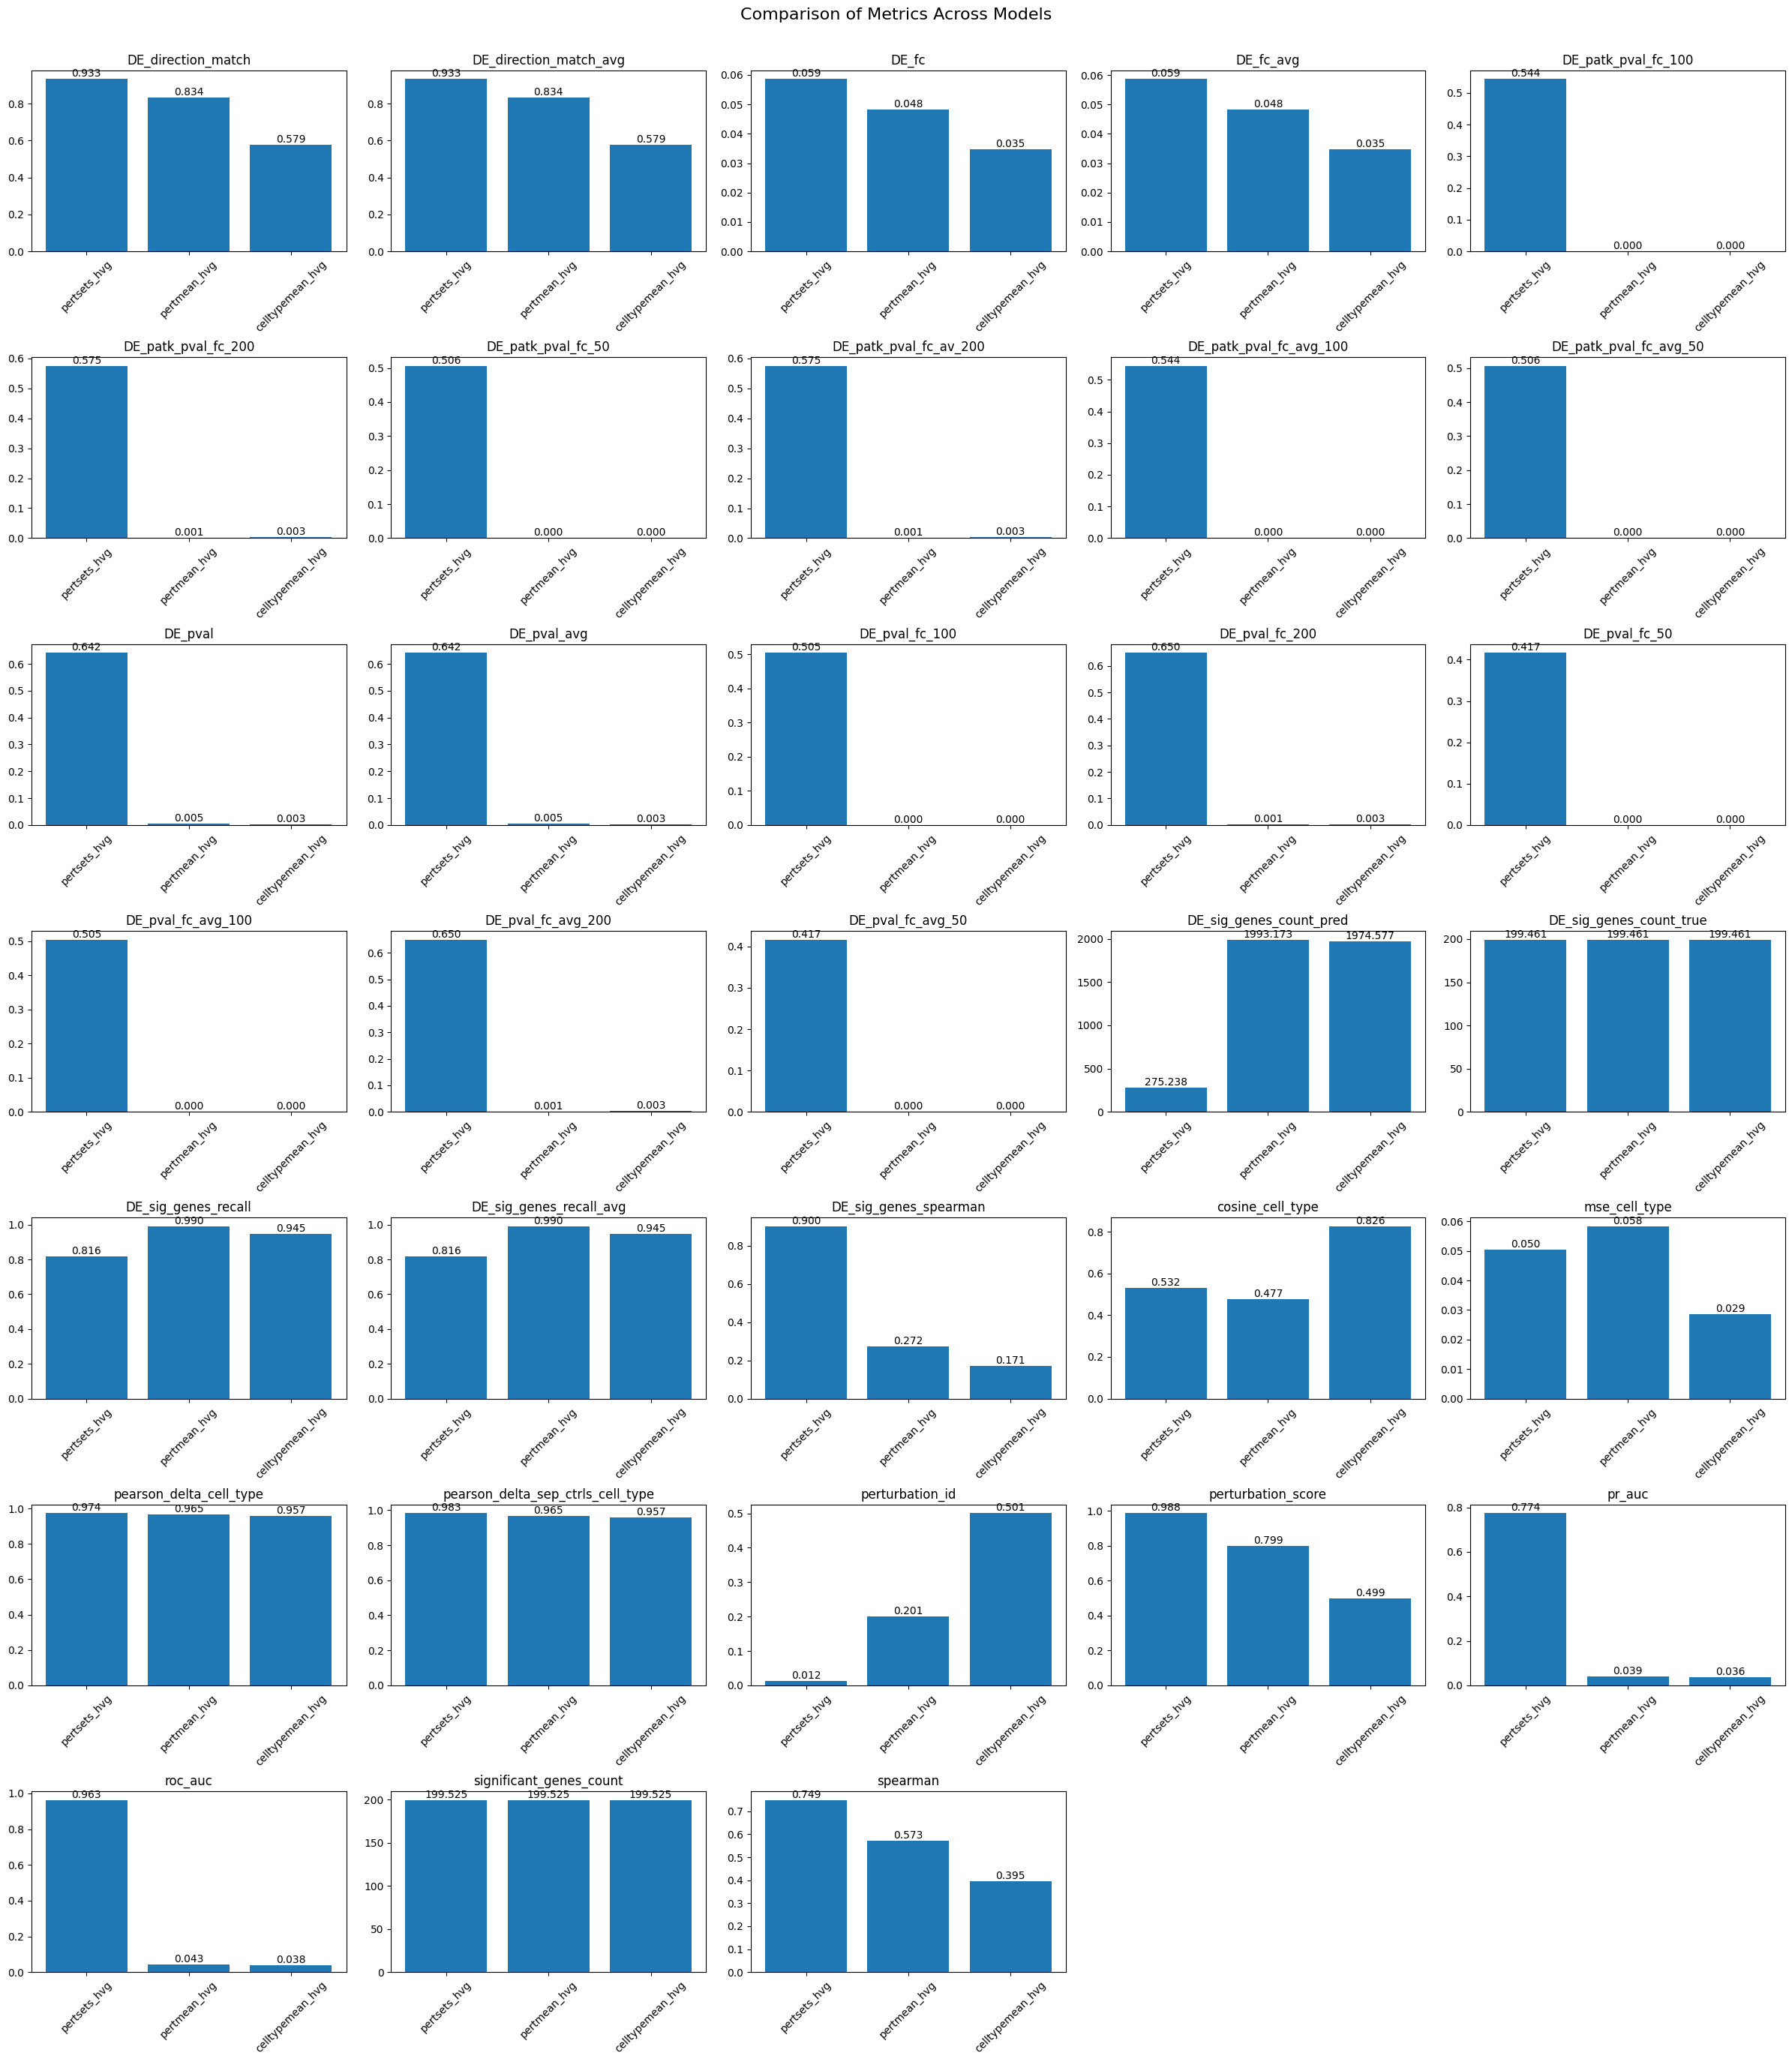

In [6]:
# Load data for each model
hvg_data = load_folds_data('/large_storage/ctc/userspace/aadduri/feb28_conc/cv_norm_samp_ctrl_30m/fold*/eval/map_random/last/metrics.csv', 'hvg')
gss_data = load_folds_data('/large_storage/ctc/userspace/aadduri/feb28_conc/cv_norm_hvg_gss/fold*/eval/map_random/final/metrics.csv', 'gss')
ctm_data = load_folds_data('/large_storage/ctc/userspace/aadduri/feb28_conc/cv_norm_hvg_ctm/fold*/eval/map_random/final/metrics.csv', 'ctm')

# Calculate aggregated metrics by model (instead of writing to CSV and reading back)
hvg_metrics = hvg_data.groupby('metric_name')['metric_val'].mean().reset_index()
gss_metrics = gss_data.groupby('metric_name')['metric_val'].mean().reset_index()
ctm_metrics = ctm_data.groupby('metric_name')['metric_val'].mean().reset_index()

# Add model name to each metrics dataframe for easier identification
hvg_metrics['model'] = 'pertsets_hvg'
gss_metrics['model'] = 'pertmean_hvg'
ctm_metrics['model'] = 'celltypemean_hvg'

# Combine all metrics into a single dataframe
all_metrics = pd.concat([hvg_metrics, gss_metrics, ctm_metrics], ignore_index=True)

# Create a pivot table for easier plotting
metrics_pivot = all_metrics.pivot(index='metric_name', columns='model', values='metric_val')

# Find shared metrics (metrics present in all three models)
shared_metrics = metrics_pivot.dropna().index.tolist()

# Define the model names as they should appear in the plot
model_names = ['pertsets_hvg', 'pertmean_hvg', 'celltypemean_hvg']

# Plot settings
num_metrics = len(shared_metrics)
num_cols = 5
num_rows = (num_metrics + num_cols - 1) // num_cols  # Ceiling division

plt.figure(figsize=(24, num_rows * 4))

# Create subplots for each metric
for i, metric in enumerate(shared_metrics):
    plt.subplot(num_rows, num_cols, i + 1)
    
    # Extract values for this metric across all models
    values = [metrics_pivot.loc[metric, model] for model in model_names]
    
    # Create bar plot
    bars = plt.bar(model_names, values)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom', rotation=0)
    
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle('Comparison of Metrics Across Models', fontsize=16)

# Save the figure
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()